---
date: 13-01-2025
author: Martin Proks
title: Mouse scANVI fix
---

Re-training of mouse model due to an estimation bug in `scvi-tools`. For more info see [summary here](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scrna/scanvi_fix.html).

In [1]:
!which pip

~/projects/data/Brickman/conda/envs/scvi-1.1.5/bin/pip


In [2]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [3]:
import scvi
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
from numba.core.errors import NumbaDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=UserWarning)

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
from rich import print
from scipy import sparse

plt.rcParams['svg.fonttype'] = 'none'

lineage_colors = {
    'Zygote': '#7985A5',
    '2C': '#B3C81E',
    '4C': '#67BB30',
    '8C': '#028A46',
    '16C': '#657cbd',
    'ICM': '#F6C445',
    'TE': '#5a94ce',
    'EPI': '#B46F9C',
    'PrE': '#D05B61'
}

ct_colors = {
    'Zygote': '#7985A5',
    '2C': '#B3C81E',
    '4C': '#67BB30',
    '8C': '#028A46',
    '16C': '#657cbd',
    'E3.25-ICM': '#fadc8f',
    'E3.25-TE': '#5185b9',
    'E3.5-ICM': '#f8d06a',
    'E3.5-TE': '#7ba9d8',
    'E3.5-EPI': '#c38cb0',
    'E3.5-PrE': '#d97c81',
    'E3.75-ICM': '#F6C445',
    'E4.5-TE': '#5a94ce',
    'E4.5-EPI': '#B46F9C',
    'E4.5-PrE': '#D05B61',
    'Unknown': 'lightgrey'
}

In [4]:
os.sys.path.append('../scripts/')
from helpers import plot_cv

In [5]:
mouse = sc.read_h5ad("../data/processed/01_mouse_reprocessed.h5ad")
mouse

AnnData object with n_obs × n_vars = 2004 × 34346
    obs: 'batch', 'experiment', 'technology', 'ct', 'ct_orig', 'stage', 'timepoint', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts'
    var: 'gene_ids', 'gene_symbol', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'log1p'
    layers: 'counts'

In [6]:
# mouse.uns['log1p']["base"] = None
# sc.pp.highly_variable_genes(
#     mouse,
#     flavor="cell_ranger",
#     n_top_genes=3_000,
#     # batch_key="batch",
#     batch_key="experiment",
#     subset=True,
# )
mouse.obs['batch_og'] = mouse.obs['batch']
mouse.obs['batch'] = mouse.obs.experiment.cat.codes.astype(str) + "_" + mouse.obs.batch.cat.codes.astype(str)

sc.pp.highly_variable_genes(mouse, flavor="seurat_v3", n_top_genes=3_000, batch_key="batch", layer='counts', subset=True)

In [9]:
mouse.uns['ct_colors'] = [ct_colors[x] for x in mouse.obs.ct.cat.categories]
mouse.uns['stage_colors'] = [lineage_colors[x] for x in mouse.obs.stage.cat.categories]

## 1. scVI

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Epoch 207/400:  52%|█████▏    | 207/400 [00:27<00:25,  7.51it/s, v_num=1, train_loss_step=5.15e+3, train_loss_epoch=6.09e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 6905.139. Signaling Trainer to stop.


<Axes: xlabel='epoch'>

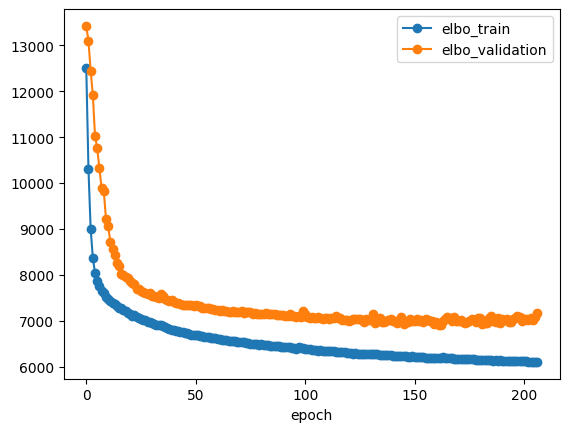

In [10]:
scvi.model.SCVI.setup_anndata(mouse, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(mouse, n_layers=2, gene_likelihood='nb')
vae.train(max_epochs=400, early_stopping=True)
pd.concat([vae.history['elbo_train'], vae.history['elbo_validation']], axis=1).plot.line(marker='o')

In [11]:
vae.save("../results/15_scANVI_fix/mouse/scvi", overwrite=True, save_anndata=True)

## 2. scANVI

In [12]:
lvae = scvi.model.SCANVI.from_scvi_model(vae, adata=mouse, labels_key="ct", unlabeled_category="Unknown")
lvae.train(max_epochs=20, n_samples_per_label=15)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Epoch 20/20: 100%|██████████| 20/20 [00:06<00:00,  3.16it/s, v_num=1, train_loss_step=4.67e+3, train_loss_epoch=6.2e+3] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:06<00:00,  3.10it/s, v_num=1, train_loss_step=4.67e+3, train_loss_epoch=6.2e+3]


In [13]:
lvae.save("../results/15_scANVI_fix/mouse/scanvi_ns15", overwrite=True, save_anndata=True)

## 3. PPC

In [14]:
from scvi.criticism import PosteriorPredictiveCheck

In [15]:
ppc = PosteriorPredictiveCheck(mouse, 
                               models_dict={'SCVI': vae, 'SCANVI': lvae}, 
                               count_layer_key='counts')

ppc.coefficient_of_variation(dim='cells')
ppc.coefficient_of_variation(dim='features')

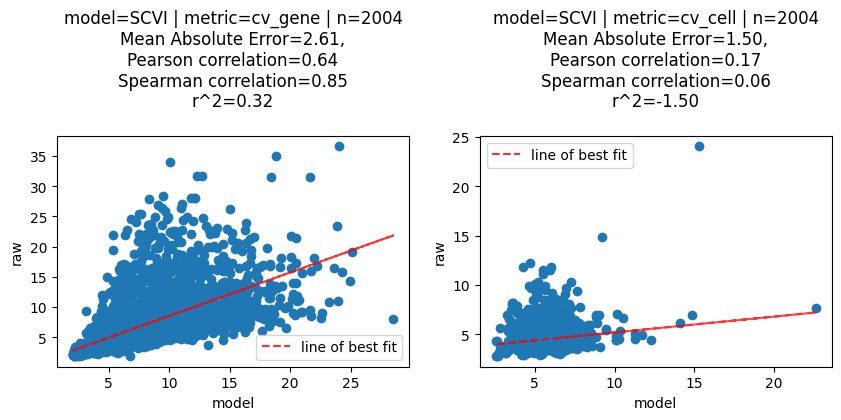

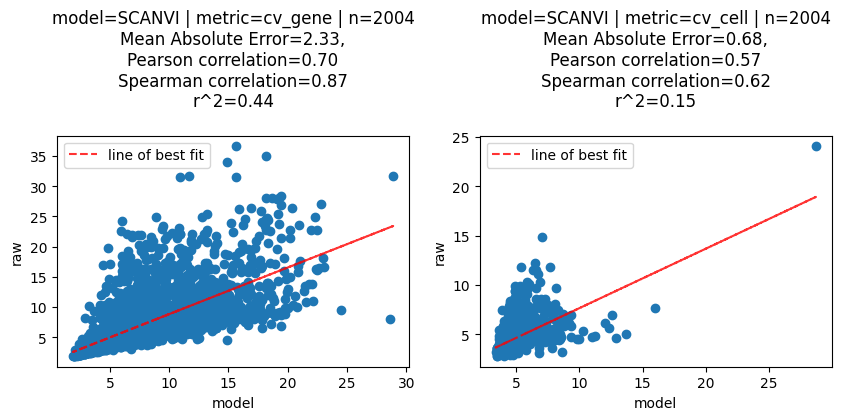

In [16]:
fig, ax = plt.subplots(1, 2, figsize=[10, 3])
plot_cv(ppc, 'SCVI', 'cv_gene', ax=ax[0])
plot_cv(ppc, 'SCVI', 'cv_cell', ax=ax[1])

fig, ax = plt.subplots(1, 2, figsize=[10, 3])
plot_cv(ppc, 'SCANVI', 'cv_gene', ax=ax[0])
plot_cv(ppc, 'SCANVI', 'cv_cell', ax=ax[1])

## 4. Benchmarker

In [17]:
from scib_metrics.benchmark import Benchmarker

In [18]:
sc.tl.pca(mouse)

In [19]:
mouse.obsm['X_scVI'] = vae.get_latent_representation()
mouse.obsm['X_scANVI'] = lvae.get_latent_representation()

In [20]:
bm = Benchmarker(
    mouse,
    batch_key="batch",
    label_key="ct",
    embedding_obsm_keys=["X_pca", "X_scVI", "X_scANVI"],
    n_jobs=6,
)
bm.benchmark()

/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.1.5/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:385: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]

INFO     E3.25-ICM consists of a single batch or is too small. Skip.                                               
INFO     E3.25-TE consists of a single batch or is too small. Skip.                                                
INFO     E3.5-EPI consists of a single batch or is too small. Skip.                                                
INFO     E3.5-PrE consists of a single batch or is too small. Skip.                                                
INFO     E3.75-ICM consists of a single batch or is too small. Skip.                                               
INFO     E4.5-TE consists of a single batch or is too small. Skip.                                                 


Embeddings:  33%|███▎      | 1/3 [00:20<00:40, 20.15s/it]

INFO     E3.25-ICM consists of a single batch or is too small. Skip.                                               
INFO     E3.25-TE consists of a single batch or is too small. Skip.                                                
INFO     E3.5-EPI consists of a single batch or is too small. Skip.                                                
INFO     E3.5-PrE consists of a single batch or is too small. Skip.                                                
INFO     E3.75-ICM consists of a single batch or is too small. Skip.                                               
INFO     E4.5-TE consists of a single batch or is too small. Skip.                                                 


Embeddings:  67%|██████▋   | 2/3 [00:24<00:11, 11.09s/it]

INFO     E3.25-ICM consists of a single batch or is too small. Skip.                                               
INFO     E3.25-TE consists of a single batch or is too small. Skip.                                                
INFO     E3.5-EPI consists of a single batch or is too small. Skip.                                                
INFO     E3.5-PrE consists of a single batch or is too small. Skip.                                                
INFO     E3.75-ICM consists of a single batch or is too small. Skip.                                               
INFO     E4.5-TE consists of a single batch or is too small. Skip.                                                 


Embeddings: 100%|██████████| 3/3 [00:28<00:00,  9.47s/it]


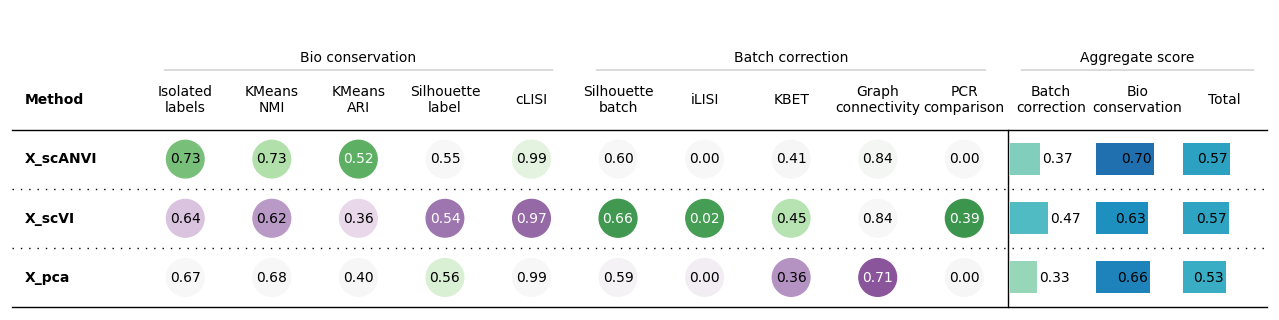

In [21]:
bm.plot_results_table(min_max_scale=False, save_dir='../results/15_scANVI_fix/mouse/')

## 5. Downstream analysis

In [22]:
lvae.adata.obsm['X_scVI'] = mouse.obsm['X_scVI']
lvae.adata.obsm['X_scANVI'] = mouse.obsm['X_scANVI']
lvae.adata.layers['scANVI_normalized'] = sparse.csr_matrix(lvae.get_normalized_expression(return_mean=True))

In [23]:
sc.tl.pca(lvae.adata)
sc.pp.neighbors(lvae.adata, use_rep='X_scANVI')
sc.tl.leiden(lvae.adata, resolution=0.8)
sc.tl.umap(lvae.adata)
sc.tl.draw_graph(lvae.adata, n_jobs=6)

/scratch/temp/fdb589/ipykernel_1136349/2187811291.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(lvae.adata, resolution=0.8)


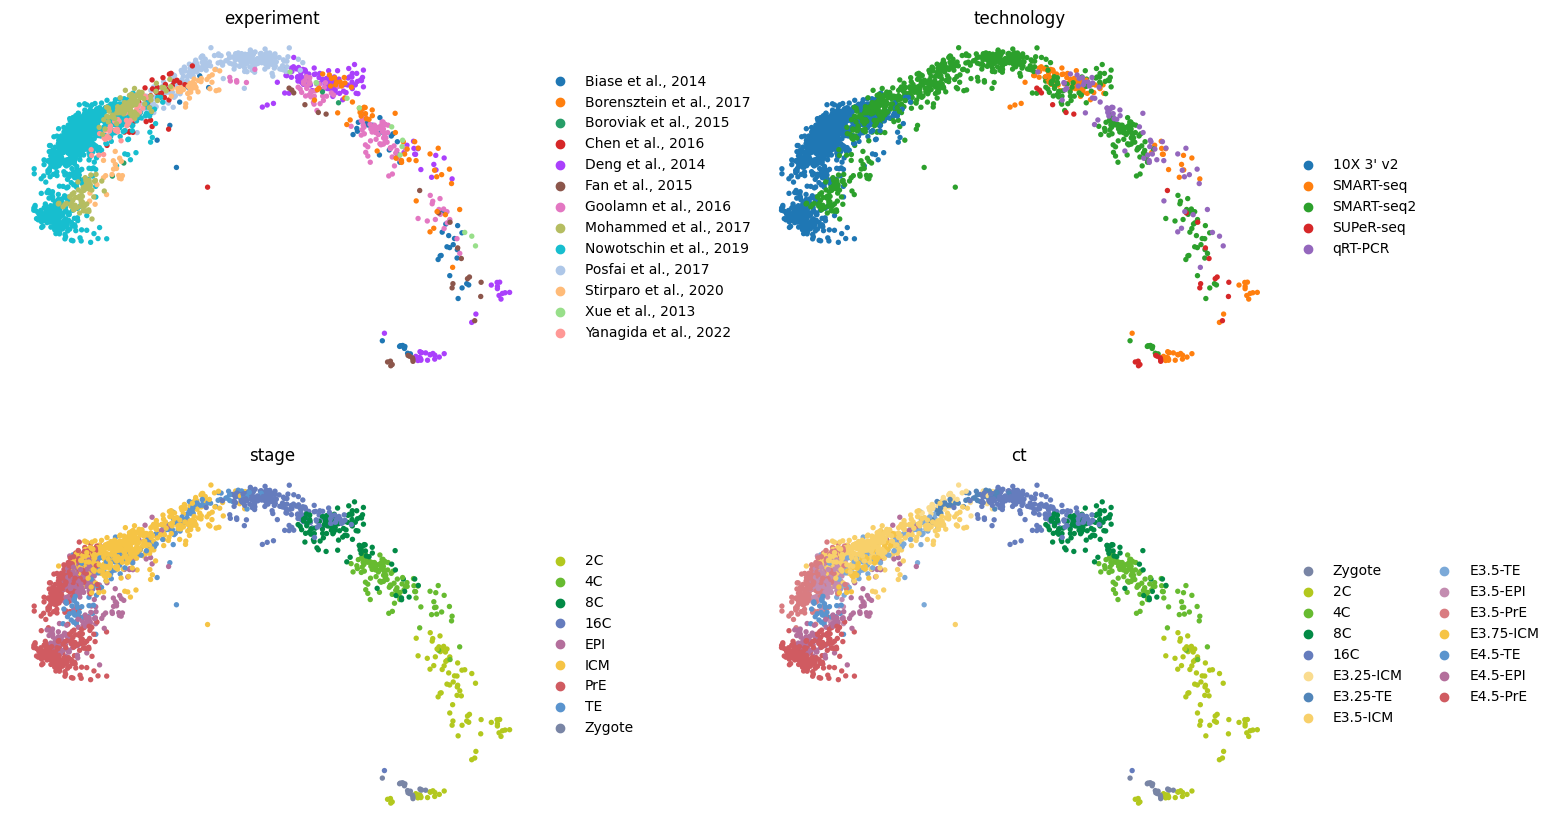

In [81]:
sc.pl.pca(lvae.adata, color=['experiment', 'technology', 'stage', 'ct'], frameon=False, ncols=2, wspace=0.3)

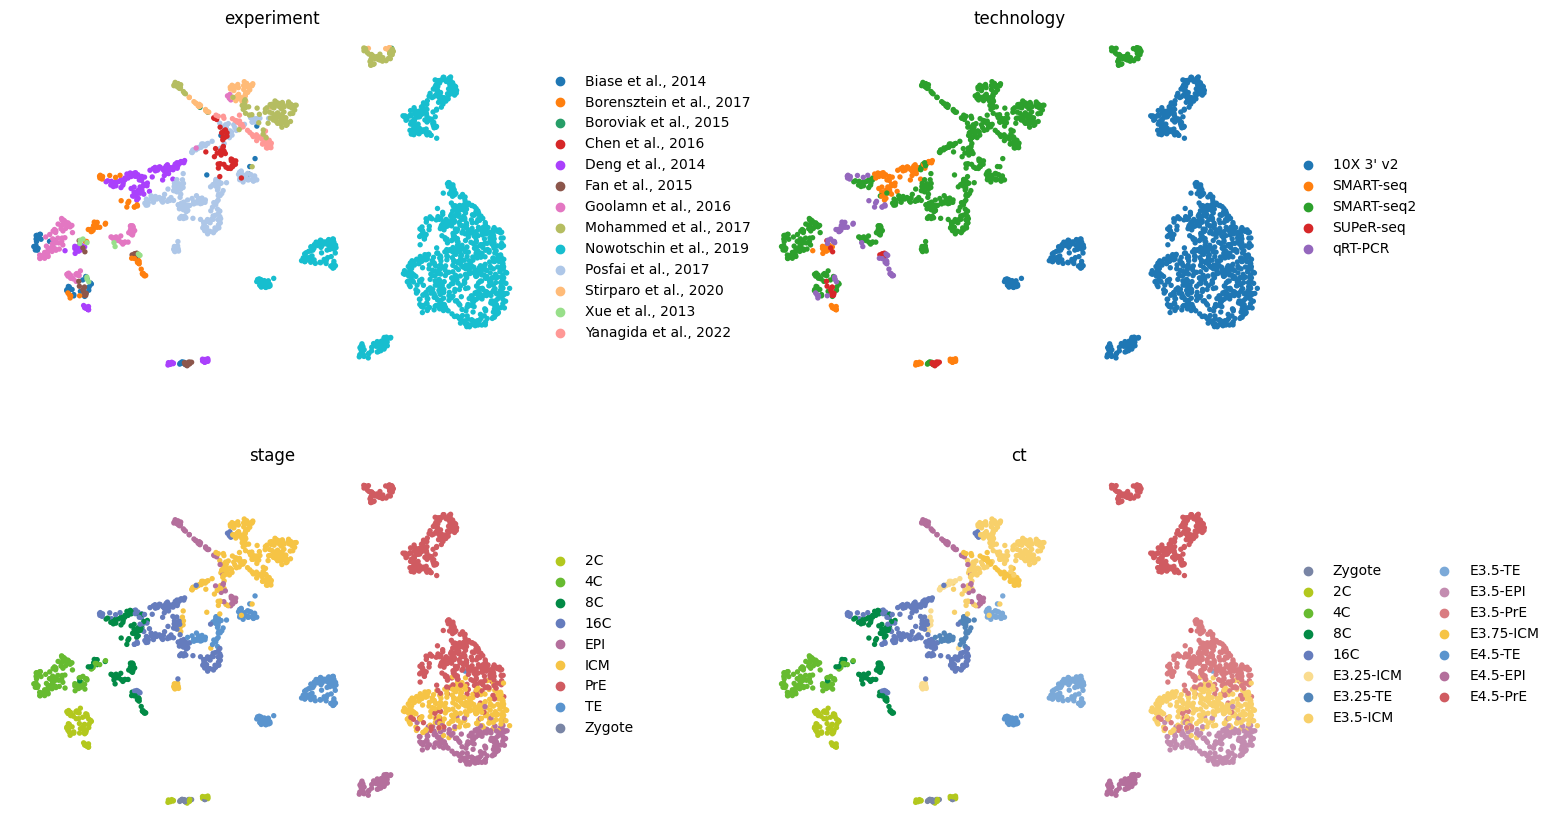

In [82]:
sc.pl.umap(lvae.adata, color=['experiment', 'technology', 'stage', 'ct'], frameon=False, ncols=2, wspace=0.3)

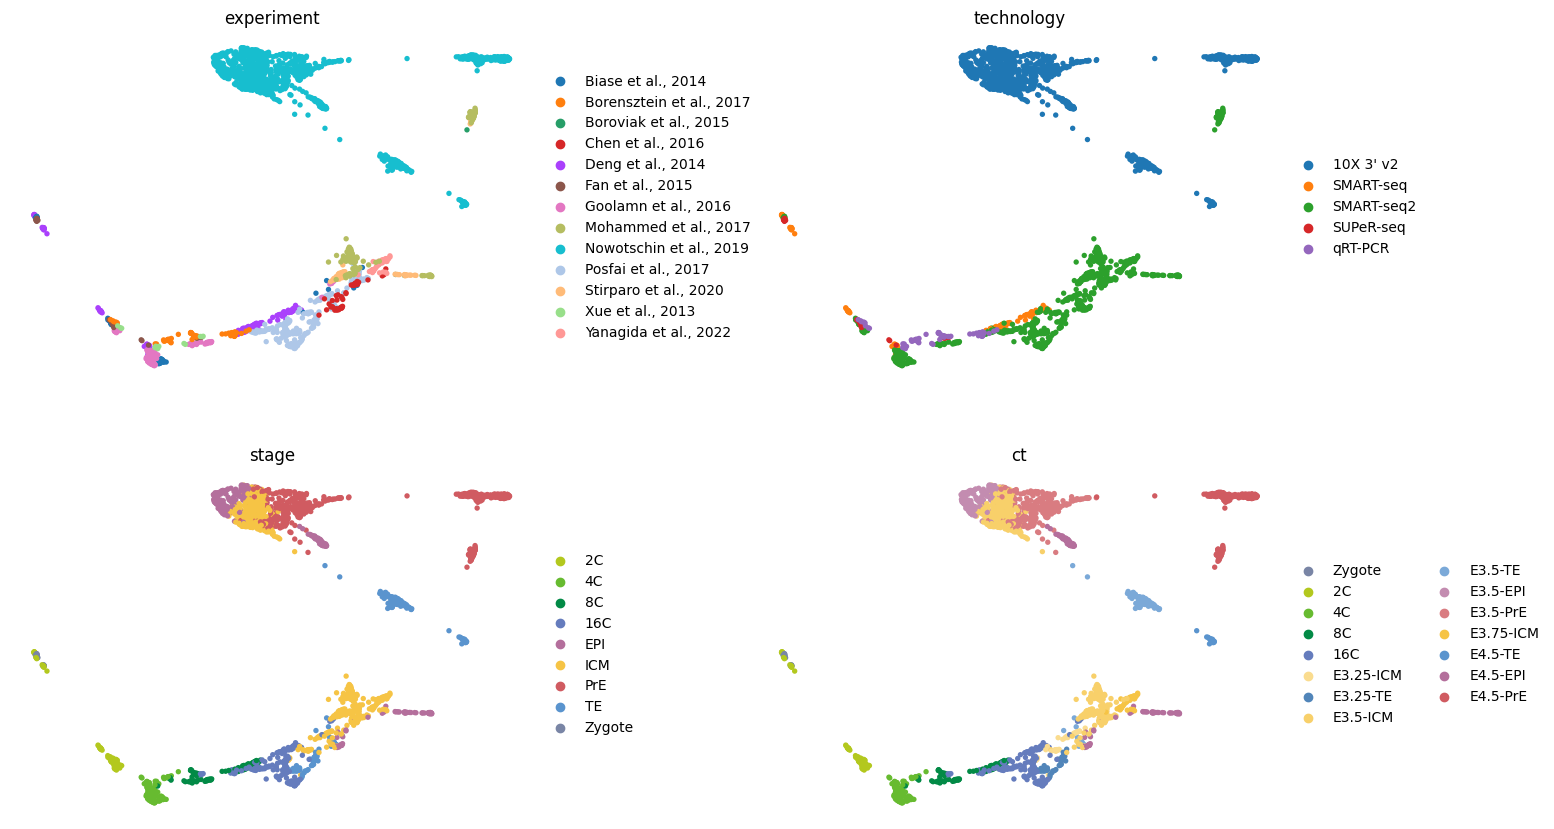

In [83]:
sc.pl.draw_graph(lvae.adata, color=['experiment', 'technology', 'stage', 'ct'], frameon=False, ncols=2, wspace=0.3)

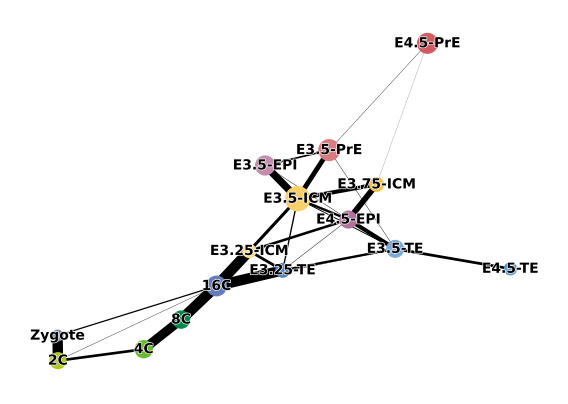

In [84]:
sc.pp.neighbors(lvae.adata, use_rep='X_scANVI')
sc.tl.diffmap(lvae.adata)

sc.tl.paga(lvae.adata, groups='ct')
sc.pl.paga(lvae.adata, color=['ct'], frameon=False, fontoutline=True)
sc.tl.draw_graph(lvae.adata, init_pos='paga', n_jobs=6)

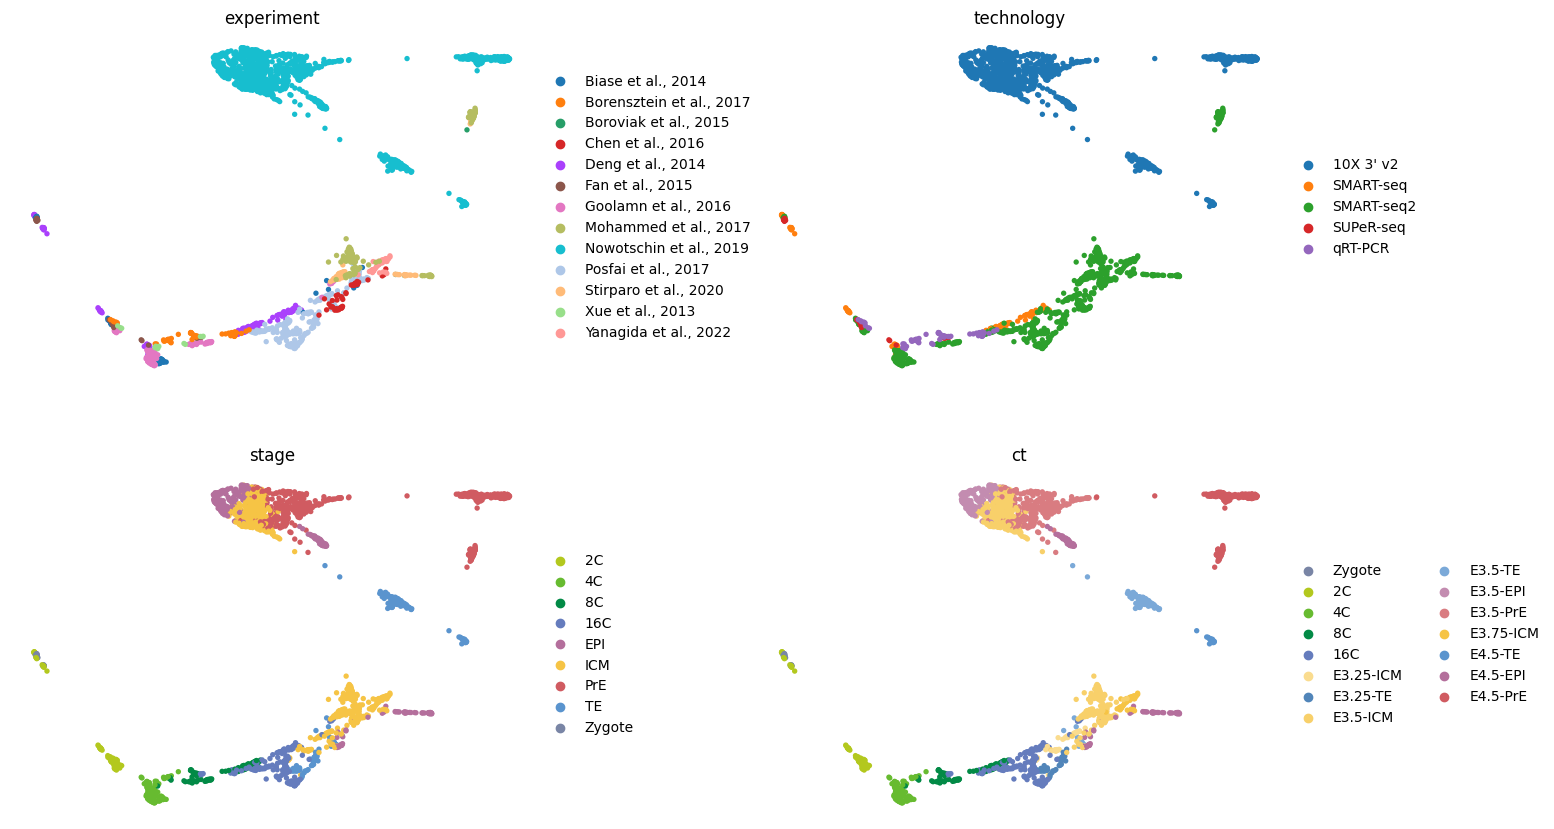

In [85]:
sc.pl.draw_graph(lvae.adata, color=['experiment', 'technology', 'stage', 'ct'], frameon=False, ncols=2, wspace=0.3)

## 6. DEGs

In [29]:
sc.tl.rank_genes_groups(lvae.adata, groupby='stage', key_added='degs_by_stage')
sc.tl.rank_genes_groups(lvae.adata, groupby='ct', key_added='degs_by_ct')

## 7. Cell Type prediction

In [30]:
lvae.adata.obs['predictions'] = lvae.predict()
lvae.adata.obs['entropy'] = 1 - lvae.predict(soft=True).max(axis=1)

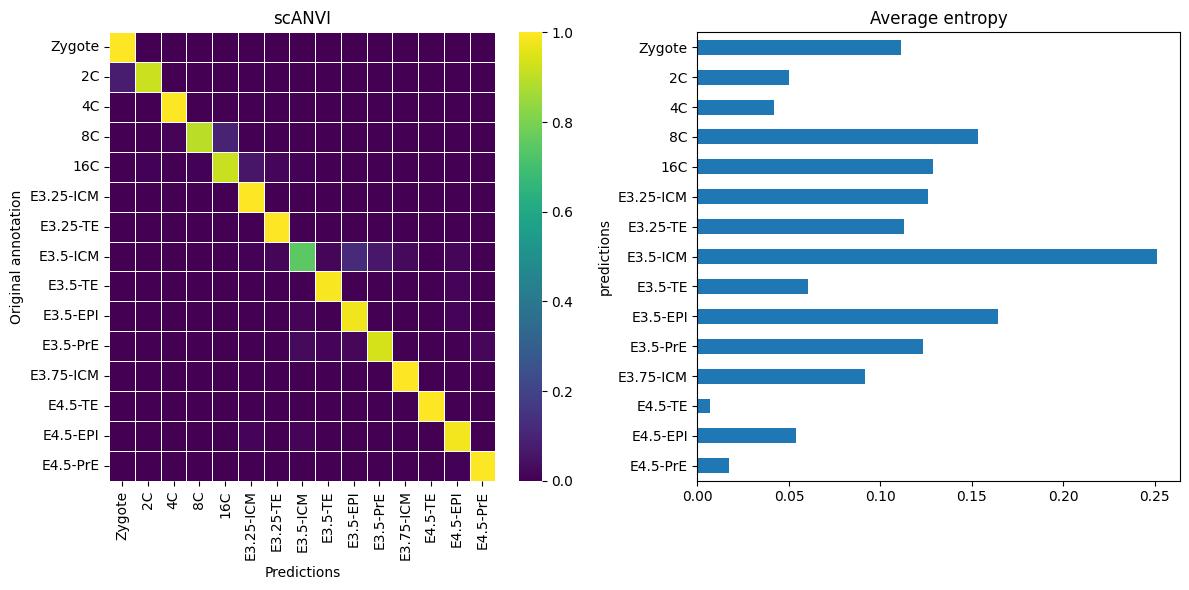

In [31]:
mtx_oder = lvae.adata.obs.ct.cat.categories.tolist()
mtx = sc.metrics.confusion_matrix("ct", "predictions", lvae.adata.obs).loc[mtx_oder, mtx_oder]
entropy = lvae.adata.obs.groupby(['predictions']).mean(numeric_only=True)['entropy'][mtx_oder]

fig, ax = plt.subplots(1, 2, figsize=[12, 6])
sns.heatmap(mtx, cmap='viridis', linewidths=0.5, vmax=1, ax=ax[0]).set(xlabel='Predictions', ylabel='Original annotation', title='scANVI')
entropy[::-1].plot.barh(ax=ax[1], title='Average entropy')
fig.tight_layout()

In [32]:
print(
    f'Accuracy score: {accuracy_score(lvae.adata.obs.ct.values, lvae.adata.obs.predictions.values)}\n'
    f'Balanced accuracy: {balanced_accuracy_score(lvae.adata.obs.ct.values, lvae.adata.obs.predictions.values)}\n'
    f'F1 (micro): {f1_score(lvae.adata.obs.ct.values, lvae.adata.obs.predictions.values, average="micro")}\n'
    f'F1 (macro): {f1_score(lvae.adata.obs.ct.values, lvae.adata.obs.predictions.values, average="macro")}'
)

Accuracy score: 0.9126746506986028
Balanced accuracy: 0.9572872718187365
F1 (micro): 0.9126746506986028
F1 (macro): 0.9201654923575322

## 8. scANVI explainer

In [33]:
from scanvi_explainer import SCANVIBoostrapper

In [34]:
bootstrapper = SCANVIBoostrapper(lvae, n_bootstraps=10)

In [35]:
shap_values = bootstrapper.run(train_size=0.8, batch_size=64)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [46]:
bootstrapper.save(shap_values, '../results/15_scANVI_fix/mouse/bootstrapped_shaps.feather')

### 8.1. Filter explainer results

In [70]:
df = pd.read_feather('../results/15_scANVI_fix/mouse/bootstrapped_shaps.feather').set_index('index')
mask = df[df.columns[:-1]].mean(axis=1) > 0.01

df_filtered = df[mask].copy()

In [72]:
df_filtered

,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,label
index,,,,,,,,,,,
h1f8,153.986666,309.807133,392.404919,539.108002,315.107775,82.086252,163.714508,73.292031,127.470892,119.207432,Zygote
bcl2l10,197.824400,206.405497,357.049444,368.092831,297.178275,111.080451,176.083078,122.311286,157.062604,163.201607,Zygote
tcl1,248.550064,194.731911,304.724413,289.041072,246.698285,116.086455,190.507908,124.366362,196.184844,209.762241,Zygote
ldhb,170.009420,152.413605,389.066422,344.779062,332.931296,131.136752,155.156263,107.304192,120.984989,196.751423,Zygote
btg4,218.517197,202.096735,309.205738,291.039707,253.122300,108.449377,188.206516,128.874479,178.977204,178.006311,Zygote
...,...,...,...,...,...,...,...,...,...,...,...
baiap2l1,0.001898,0.023267,0.023370,0.023609,0.001952,0.002527,0.000927,0.000746,0.005561,0.027188,E4.5-PrE
trim43a,0.010471,0.010393,0.010641,0.010701,0.010841,0.010841,0.010906,0.011103,0.010861,0.010089,E4.5-PrE
cript,0.015460,0.024873,0.011048,0.012553,0.006466,0.002868,0.002105,0.002022,0.007488,0.021723,E4.5-PrE


In [77]:
lvae.adata.uns['explainer'] = {
    'bootstrapper': {
        'n_bootstraps': 10,
        'train_size': 0.8,
        'batch_size': 64,
        'shap_values': df_filtered
    }
}

## 9. Save results

In [99]:
lvae.adata.write('../results/15_scANVI_fix/mouse/scanvi_ns15/adata.h5ad')

In [100]:
!du -h ../results/15_scANVI_fix/mouse/scanvi_ns15/adata.h5ad

/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.1.5/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


221M	../results/15_scANVI_fix/mouse/scanvi_ns15/adata.h5ad
